In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import pathlib

Get batches of images from the directory/subdirectory

In [ ]:
IMAGE_HEIGHT =255
IMAGE_WIDTH = 255
batch_size =9
channel=3
epoch=15
dataset=tf.keras.preprocessing.image_dataset_from_directory( "/content/drive/MyDrive/MyDrive/Data",
                                                    shuffle=True,
                                                    image_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
                                                    batch_size=batch_size)

Found 119 files belonging to 3 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class_names=dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

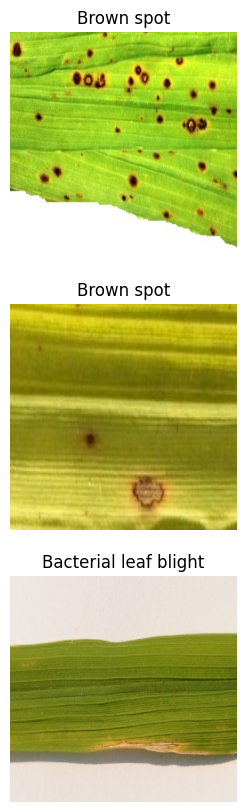

In [ ]:
plt.figure(figsize=(10,10))
for image,label in dataset.take(1):
    for i in range(3):
        plt.subplot(3,1,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

Split the train test and validation dataset

In [ ]:
def get_dataset_partitions_tf(ds,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_Size=1000):
    
    ds_size=len(ds)
    print(len(ds))
    if shuffle:
        ds = ds.shuffle(shuffle_Size,seed=12)
    train_size = int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds =ds.skip(train_size).skip(val_size)
    return train_ds, test_ds,val_ds

In [ ]:
train_ds, test_ds,val_ds = get_dataset_partitions_tf(dataset)

14


Cache and prefetch the dataset which will save some operations from being executd during each epoch

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Data normalization or rescale and resizing involves transforming the pixel values of the input images so that they fall within a specific range, typically [0, 1].By scaling the pixel values, normalization also makes it easier for the neural network to learn the underlying patterns in the data. This is because the weights in the neural network can be updated more easily and quickly when the input data has a similar scale.

In [ ]:
 resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT,IMAGE_WIDTH),
  layers.experimental.preprocessing.Rescaling(1.0/255)
 ])

Data augmentation is the process of broadening the dataset to enhance the model’s performance by generating different forms of images.
With the help of data augmentation, more images are generated from each image to train the model since some relevant or irrelevant patterns may be visible during the training process of the model. 
Randomly flips(horizontal and vertical) the images and rotational transformations are applied on them and multiple new images are generated from a single image.

In [ ]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape=(batch_size, IMAGE_HEIGHT,IMAGE_WIDTH,channel)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(16,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
        layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(63,activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history= model.fit(
    train_ds,
    epochs=75,
    
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/75
11/11 [==============================] - 23s 988ms/step - loss: 1.1369 - accuracy: 0.2826 - val_loss: 1.1740 - val_accuracy: 0.3333
Epoch 2/75
11/11 [==============================] - 6s 568ms/step - loss: 1.0983 - accuracy: 0.3804 - val_loss: 1.0847 - val_accuracy: 0.5556
Epoch 3/75
11/11 [==============================] - 5s 493ms/step - loss: 1.0913 - accuracy: 0.4130 - val_loss: 1.0547 - val_accuracy: 0.6667
Epoch 4/75
11/11 [==============================] - 8s 709ms/step - loss: 1.0790 - accuracy: 0.3696 - val_loss: 1.1281 - val_accuracy: 0.3333
Epoch 5/75
11/11 [==============================] - 5s 497ms/step - loss: 1.0848 - accuracy: 0.3587 - val_loss: 0.9502 - val_accuracy: 0.6667
Epoch 6/75
11/11 [==============================] - 5s 489ms/step - loss: 1.0332 - accuracy: 0.4565 - val_loss: 1.1195 - val_accuracy: 0.3333
Epoch 7/75
11/11 [==============================] - 7s 629ms/step - loss: 1.0370 - accuracy: 0.5435 - val_loss: 0.9661 - val_accuracy: 0.4444
Epoch

In [ ]:
  score= model.evaluate(test_ds)

2/2 [==============================] - 2s 156ms/step - loss: 0.4240 - accuracy: 0.8333


In [ ]:
    score= model.evaluate(train_ds)

11/11 [==============================] - 3s 242ms/step - loss: 0.3925 - accuracy: 0.8478


In [ ]:
score= model.evaluate(val_ds)

1/1 [==============================] - 0s 223ms/step - loss: 0.4950 - accuracy: 0.7778


In [ ]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

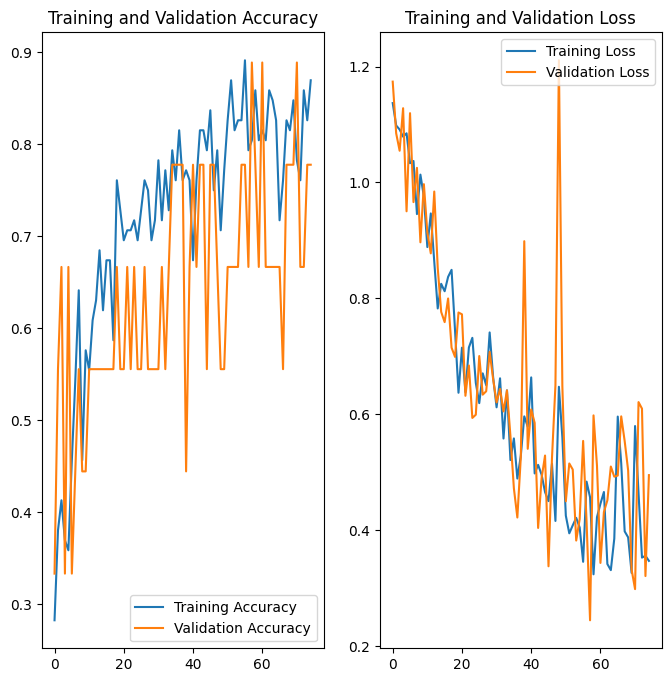

In [ ]:
EPOCHS=75
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
import numpy as np
def prediction(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0) 
  predict=model.predict(img_array)
  predicted_class = class_names[np.argmax(predict[0])]
  confidence= round(100*(np.max(predict[0])),2)
  return predicted_class,confidence


1/1 [==============================] - 0s 37ms/step


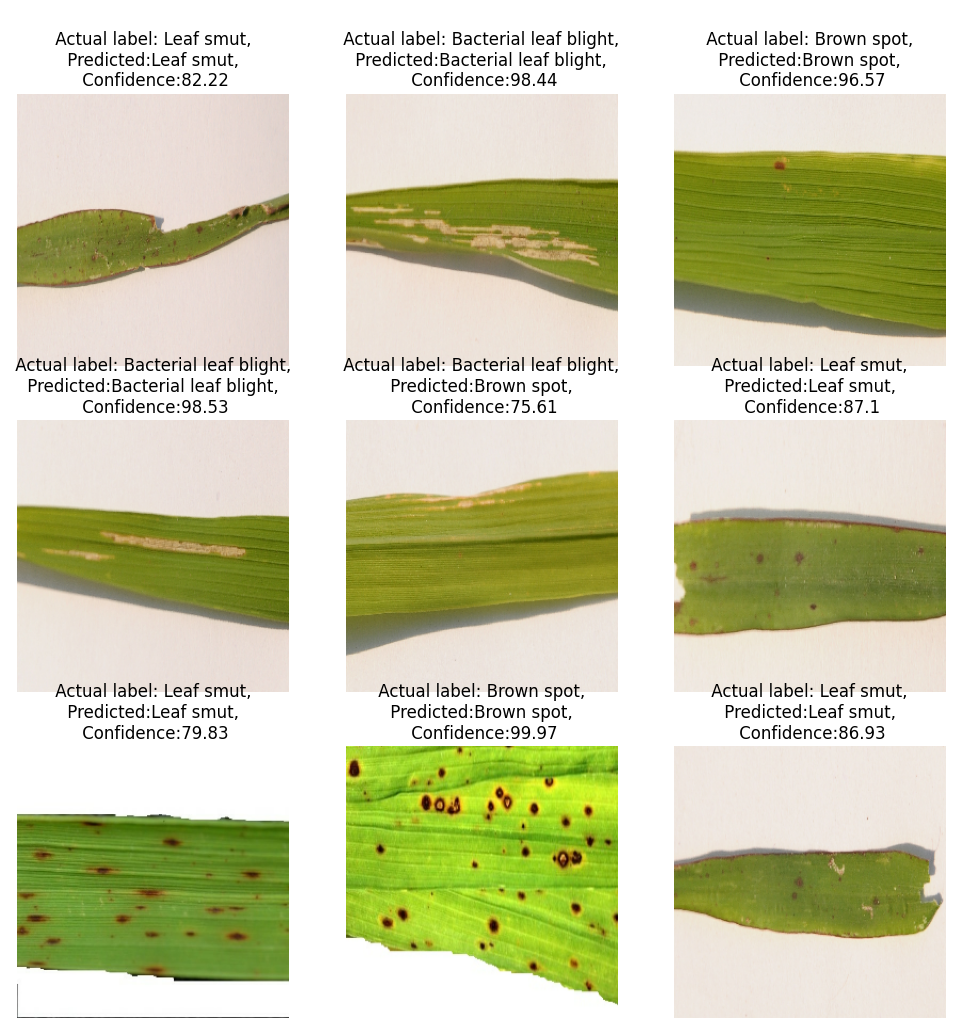

In [ ]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
     for i in range(9):
           ax = plt.subplot(3,3,i+1)
           plt.imshow(images[i].numpy().astype('uint8'))
           predicted_class,confidence = prediction(model, images[i].numpy())
           actual_class = class_names[labels[i]]
           plt.title(f' \n Actual label: {actual_class}, \n Predicted:{predicted_class}, \n Confidence:{confidence}' )
           plt.axis('off')

## Transfer Learning Techniques:

ResNet

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
input_folder ='/content/drive/MyDrive/MyDrive/Data'
output ='/content/drive/MyDrive/MyDrive/output'

In [ ]:
import splitfolders
splitfolders.ratio(input_folder, output=output, seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 119 files [00:25,  4.71 files/s]


In [ ]:
IMAGE_SIZE = [224,224]
train_path = '/content/drive/MyDrive/MyDrive/output/train'
test_path ='/content/drive/MyDrive/MyDrive/output/test'
val_path ='/content/drive/MyDrive/MyDrive/output/val'

In [ ]:
resnet= ResNet50(input_shape=IMAGE_SIZE+[3], weights='imagenet',include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in resnet.layers:
  layer.trainable = False

In [ ]:
folders=glob('/content/drive/MyDrive/MyDrive/output/train/*')


In [ ]:
x=Flatten()(resnet.output)

In [ ]:
prediction= Dense(len(folders),activation='softmax')(x)
model=Model(inputs=resnet.input,outputs=prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(optimizer='adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=32,class_mode='categorical')
testing_set=test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,class_mode='categorical')
val_set=val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,class_mode='categorical')

Found 95 images belonging to 3 classes.
Found 13 images belonging to 3 classes.
Found 11 images belonging to 3 classes.


In [ ]:
history= model.fit(training_set, validation_data=val_set,
    epochs=25,
    batch_size=3,
    verbose=1,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set)
)

Epoch 1/25
3/3 [==============================] - 33s 9s/step - loss: 8.3767 - accuracy: 0.2737 - val_loss: 1.9039 - val_accuracy: 0.3636
Epoch 2/25
3/3 [==============================] - 28s 9s/step - loss: 4.0660 - accuracy: 0.3263 - val_loss: 5.0844 - val_accuracy: 0.3636
Epoch 3/25
3/3 [==============================] - 30s 10s/step - loss: 3.7143 - accuracy: 0.3474 - val_loss: 1.9958 - val_accuracy: 0.3636
Epoch 4/25
3/3 [==============================] - 35s 10s/step - loss: 3.1342 - accuracy: 0.3368 - val_loss: 3.2652 - val_accuracy: 0.2727
Epoch 5/25
3/3 [==============================] - 29s 10s/step - loss: 2.1738 - accuracy: 0.3895 - val_loss: 2.5128 - val_accuracy: 0.3636
Epoch 6/25
3/3 [==============================] - 29s 10s/step - loss: 2.3588 - accuracy: 0.3368 - val_loss: 1.9983 - val_accuracy: 0.3636
Epoch 7/25
3/3 [==============================] - 40s 10s/step - loss: 1.6791 - accuracy: 0.3579 - val_loss: 1.7973 - val_accuracy: 0.5455
Epoch 8/25
3/3 [=============

In [ ]:
score = model.evaluate(training_set)

3/3 [==============================] - 23s 7s/step - loss: 0.7725 - accuracy: 0.6211


In [ ]:
score = model.evaluate(val_set)

1/1 [==============================] - 2s 2s/step - loss: 0.9023 - accuracy: 0.5455


In [ ]:
score = model.evaluate(testing_set)

1/1 [==============================] - 4s 4s/step - loss: 1.0270 - accuracy: 0.5385


In [ ]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

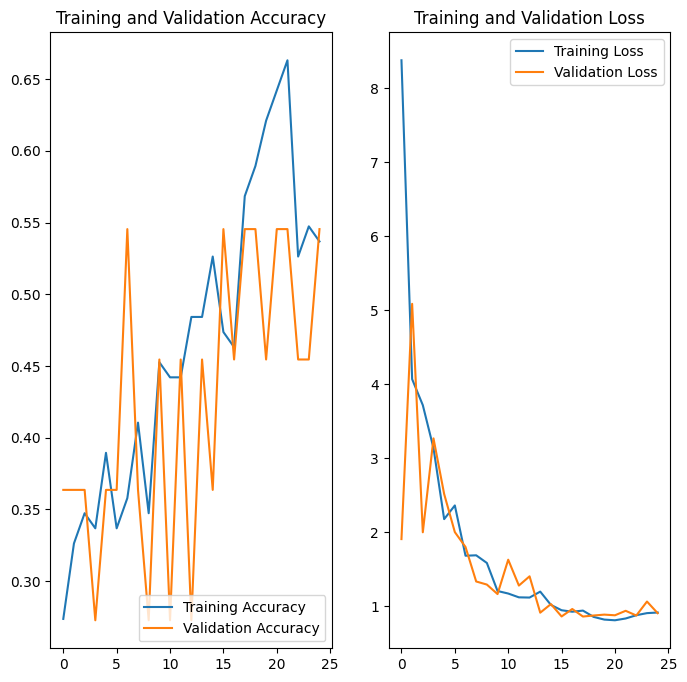

In [ ]:
EPOCHS=25
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Inception

In [ ]:
inception= InceptionV3(input_shape=IMAGE_SIZE+[3], weights='imagenet',include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inception.layers:
  layer.trainable = False

In [ ]:
folders

['/content/drive/MyDrive/MyDrive/output/train/Bacterial leaf blight',
 '/content/drive/MyDrive/MyDrive/output/train/Leaf smut',
 '/content/drive/MyDrive/MyDrive/output/train/Brown spot']

In [ ]:
x=Flatten()(inception.output)


In [ ]:
prediction= Dense(len(folders),activation='softmax')(x)
model=Model(inputs=inception.input,outputs=prediction)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                           

In [ ]:
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [ ]:
history= model.fit(training_set, validation_data=val_set,
    epochs=25,
    batch_size=3,
    verbose=1,
    validation_steps=len(val_set)
   # callbacks=[callback]
)

Epoch 1/25
3/3 [==============================] - 29s 7s/step - loss: 1.6710 - accuracy: 0.5474 - val_loss: 2.6392 - val_accuracy: 0.5455
Epoch 2/25
3/3 [==============================] - 20s 6s/step - loss: 0.7112 - accuracy: 0.8632 - val_loss: 1.0220 - val_accuracy: 0.7273
Epoch 3/25
3/3 [==============================] - 18s 6s/step - loss: 0.2069 - accuracy: 0.9474 - val_loss: 0.8705 - val_accuracy: 0.9091
Epoch 4/25
3/3 [==============================] - 19s 7s/step - loss: 0.2196 - accuracy: 0.9579 - val_loss: 1.1149 - val_accuracy: 0.7273
Epoch 5/25
3/3 [==============================] - 19s 5s/step - loss: 0.0322 - accuracy: 0.9789 - val_loss: 1.6310 - val_accuracy: 0.7273
Epoch 6/25
3/3 [==============================] - 19s 7s/step - loss: 0.3666 - accuracy: 0.9158 - val_loss: 1.2324 - val_accuracy: 0.7273
Epoch 7/25
3/3 [==============================] - 18s 5s/step - loss: 0.1446 - accuracy: 0.9789 - val_loss: 0.6199 - val_accuracy: 0.8182
Epoch 8/25
3/3 [==================

In [ ]:
  score= model.evaluate(testing_set)

1/1 [==============================] - 2s 2s/step - loss: 1.8043 - accuracy: 0.8462


In [ ]:
score= model.evaluate(training_set)

3/3 [==============================] - 17s 4s/step - loss: 5.6002e-04 - accuracy: 1.0000


In [ ]:
score= model.evaluate(val_set)

1/1 [==============================] - 2s 2s/step - loss: 0.3266 - accuracy: 0.9091


In [ ]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

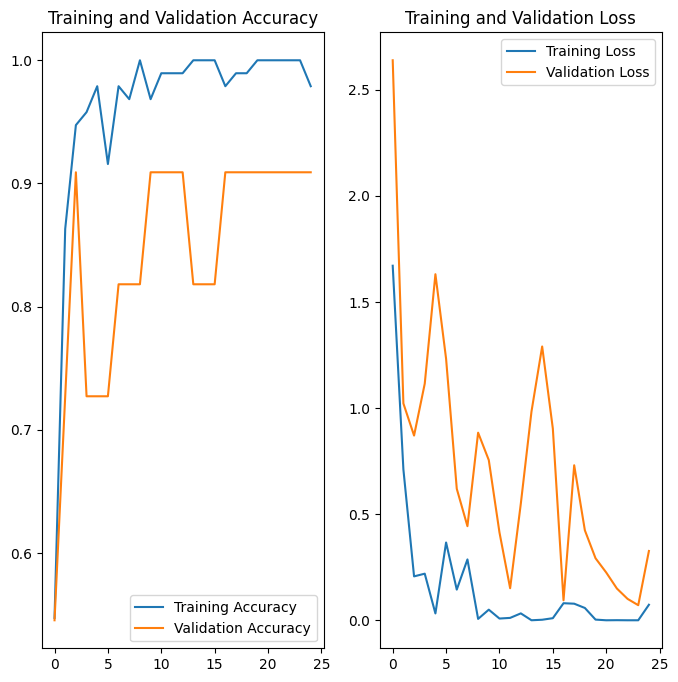

In [ ]:
EPOCHS=25
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Xception

In [ ]:
xception= Xception(input_shape=IMAGE_SIZE+[3], weights=None,include_top=False)

In [ ]:
for layer in xception.layers:
  layer.trainable = False

In [ ]:
x=Flatten()(xception.output)

In [ ]:
prediction= Dense(len(folders),activation='softmax')(x)
model_xcpt=Model(inputs=xception.input,outputs=prediction)
model_xcpt.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

In [ ]:
model_xcpt.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history= model_xcpt.fit(training_set, validation_data=val_set,
    epochs=50,
    batch_size=3,
    verbose=1,
   # steps_per_epoch=len(training_set),
    validation_steps=len(val_set)
    #,callbacks=callback
)

Epoch 1/50
3/3 [==============================] - 35s 10s/step - loss: 0.6928 - accuracy: 0.2737 - val_loss: 0.6921 - val_accuracy: 0.3636
Epoch 2/50
3/3 [==============================] - 30s 10s/step - loss: 0.6918 - accuracy: 0.3368 - val_loss: 0.6911 - val_accuracy: 0.3636
Epoch 3/50
3/3 [==============================] - 33s 11s/step - loss: 0.6907 - accuracy: 0.3684 - val_loss: 0.6900 - val_accuracy: 0.3636
Epoch 4/50
3/3 [==============================] - 30s 10s/step - loss: 0.6896 - accuracy: 0.4000 - val_loss: 0.6889 - val_accuracy: 0.3636
Epoch 5/50
3/3 [==============================] - 30s 10s/step - loss: 0.6884 - accuracy: 0.4000 - val_loss: 0.6878 - val_accuracy: 0.3636
Epoch 6/50
3/3 [==============================] - 33s 11s/step - loss: 0.6873 - accuracy: 0.3789 - val_loss: 0.6867 - val_accuracy: 0.3636
Epoch 7/50
3/3 [==============================] - 32s 11s/step - loss: 0.6862 - accuracy: 0.3789 - val_loss: 0.6856 - val_accuracy: 0.3636
Epoch 8/50
3/3 [===========

In [ ]:
  score= model_xcpt.evaluate(testing_set)

1/1 [==============================] - 5s 5s/step - loss: 0.6532 - accuracy: 0.3077


In [ ]:
score= model_xcpt.evaluate(training_set)

3/3 [==============================] - 27s 9s/step - loss: 0.6523 - accuracy: 0.4421


In [ ]:
score= model_xcpt.evaluate(val_set)

1/1 [==============================] - 4s 4s/step - loss: 0.6529 - accuracy: 0.4545


In [ ]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

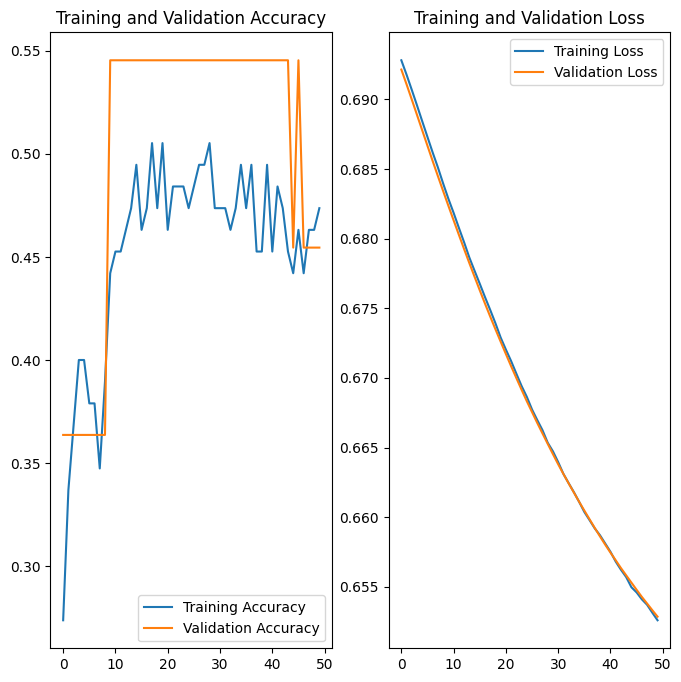

In [ ]:
EPOCHS=50
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')